# ECG filtering via Deep Learning
*Author: Christopher Korfmann*

This is a sample of ECG filter using deep learning. This uses the Keras library from Tensorflow.

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from keras import models
from typing import Union


### **1.** Load Keras model

The model used was trained on ECG data obtained from a Biopac device. It was saved in *.h5* format. The pretrained model is loaded in this cell.

In [50]:
model_path = "./ecg_filter.h5" # path to Keras model

ecg_filter = models.load_model(
    model_path,
    compile=True,
)


### **2.** Helper functions

These are helper functions used to generate artificial ECG noise and artifacts.

In [51]:
def resize1D(sequence: Union[list, np.ndarray], new_len: int) -> np.ndarray:
    """
    Resizes one dimensional list or array using linear interpolation.

    Parameters
    --------
    sequence: list or array of int or float
        1-D sequence to be resized.
    
    new_len: integer
        Length of new array.

    Returns
    --------
    resized_array: ndarray
        1-D array of length `new_len`.

    Example
    --------

    Upsizing:
    
    >>> resize2D([1, 2], 5)
    array([1.  , 1.25, 1.5 , 1.75, 2.  ])
    >>> resize2D([1, 3.14, -2], 4)
    array([ 1.        ,  2.42666667,  1.42666667, -2.        ])

    Downsizing:

    >>> resize2D([1.5, 7, 4.75, 10], 3)
    array([ 1.5  ,  5.875, 10.   ])
    """
    try:
        if type(sequence) is np.ndarray:
            dims = sequence.ndim
            arr_shape = sequence.shape

            if dims > 2:
                raise ValueError(f"Must be 1-D array. Found {dims} dimensions.")
            elif len(arr_shape) > 1:
                if not 1 in sequence.shape:
                    raise ValueError(f"Must be 1-D array. Found shape {dims}.")
                else:
                    sequence = sequence.ravel()

        old_len = len(sequence)

        return np.interp(
            x=np.linspace(start=0, stop=old_len - 1, num=new_len),
            xp=np.arange(stop=old_len),
            fp=sequence
        )
    except ValueError as e:
        print(e)
 
def generate_lead_noise_2D(sample_length: int) -> np.ndarray:
    """
    Generates a 2-D random, zero-centered ECG lead noise signal with abrumpt motion artifact. 

    Parameters
    --------
    sample_length: integer
        Noise signal length

    Returns
    --------
    lead_noise: ndarray
        2-D array of length `sample_length`.

    Example
    --------
    
    >>> generate_lead_noise_2D(4)
    array([[-0.07798717],
           [-0.02599572],
           [ 0.02599572],
           [ 0.07798717]])
    """

    noisy_leads = np.ones(shape=sample_length)
    noisy_leads = noisy_leads * np.abs(np.random.normal(0,1,size=sample_length))

    abrupt_motion = np.zeros(sample_length)
    abrupt_motion_position = np.random.randint(0, sample_length)
    abrupt_motion_duration = np.random.randint(0, sample_length-abrupt_motion_position)

    abrupt_motion[abrupt_motion_position:abrupt_motion_position+abrupt_motion_duration] = np.random.normal(0,0.7)*np.hanning(abrupt_motion_duration)

    if sample_length < 75:
        window_length = sample_length // 3
    else:
        window_length = 75
    noisy_leads = np.convolve(
        noisy_leads,
        np.ones(window_length)
    )
    noisy_leads = noisy_leads[window_length:-window_length] / noisy_leads[window_length:-window_length].mean()

    return np.array([resize1D(noisy_leads, new_len=sample_length) - 1 + abrupt_motion]).T
    

### **3.** Load ECG dataset

The ECG dataset is loaded in this section. It is loaded from a *.txt* file in CSV format (i.e. it is comma separated). It contains roughly 2 minutes and 20 seconds of ECG data, sampled at a frequency of 1000Hz. The signal is measured in millivolts.

The next cell loads the dataset and randomly generates approximately 15,000 1 second samples. The samples are arranged in the following format:
`(total_samples, sample_length, sample_dimension, batch_size)`

where,
    
    total_samples = total number of 1 second samples
    sample_length = length of each sample (1000)
    sample_dimension = dimensionality of sample (1)
    batch_size = size of inference batch for model (1)


In [52]:
usecols = 1
skiprows = 11

ecgdata_path = "./ECG.txt" # path to ECG data 

with open(file=ecgdata_path, mode='r') as f:
    data = np.array(np.hsplit(np.loadtxt(
                fname=f,
                delimiter=',',
                usecols=usecols,
                skiprows=skiprows),1)).ravel()

    ecg = np.array(data)


sample_length = 1_000   # 1 second at 1000Hz
bucket_size = 15_000    # 15,000 samples

depth, height, width = 1, 1, sample_length
input_shape = None, width, height, 1


sample_indices = np.random.randint(low=0, high=ecg.size, size=bucket_size)
sample_list = [ ecg[i:i+sample_length]
                 for i
                 in sample_indices ]

count = 0
for i in range(5):
    for j, sample in enumerate(sample_list):
        if not len(sample) == sample_length:
            sample_list.pop(j)

X_valid = np.array(
                    [ np.expand_dims(sample, axis=(1,2)) 
                        for sample
                        in np.array(sample_list) ]
                )

print(f"""\
    Dataset dimensions:
    {input_shape    = }
    {X_valid.shape  = }
""")


    Dataset dimensions:
    input_shape    = (None, 1000, 1, 1)
    X_valid.shape  = (14885, 1000, 1, 1)



A random 1 second ECG sample is plotted in *Figure 3.1*

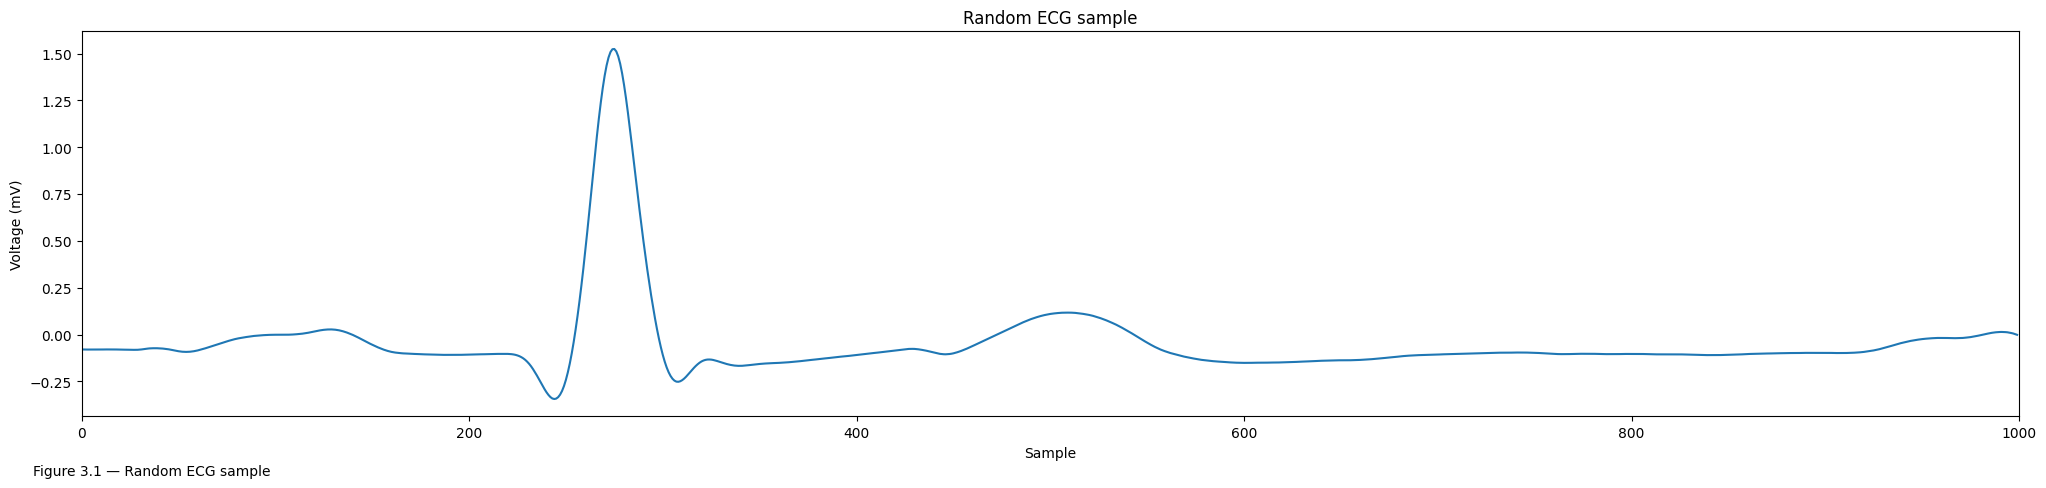

In [73]:
random_sample_index = np.random.randint(low=0, high=X_valid.shape[0])

plt.figure(figsize=(25,5))
plt.plot(X_valid[random_sample_index,:,0,0])
plt.xlim([0,sample_length])
plt.title("Random ECG sample")
plt.xlabel("Sample")
plt.ylabel("Voltage (mV)")
plt.text(
    x=-25,
    y=-.75,
    s="Figure 3.1 — Random ECG sample"
)
plt.show()


### **4.** Generate noisy sample and plot filtered signal

This cell picks a random sample and adds drift, a bump artifact, and noise to the signal, then runs inference through the model. The resulting model is the filtered signal, which is plotted below.

*Figure 4.1* shows the original signal, the signal with added noise and artifacts (input signal to the model), the predicted position of the QRS wave from the model output, and the actual position of the QRS wave. *Figure 4.2* shows the original signal before added noise and artifacts, and the filtered signal (output to the model).

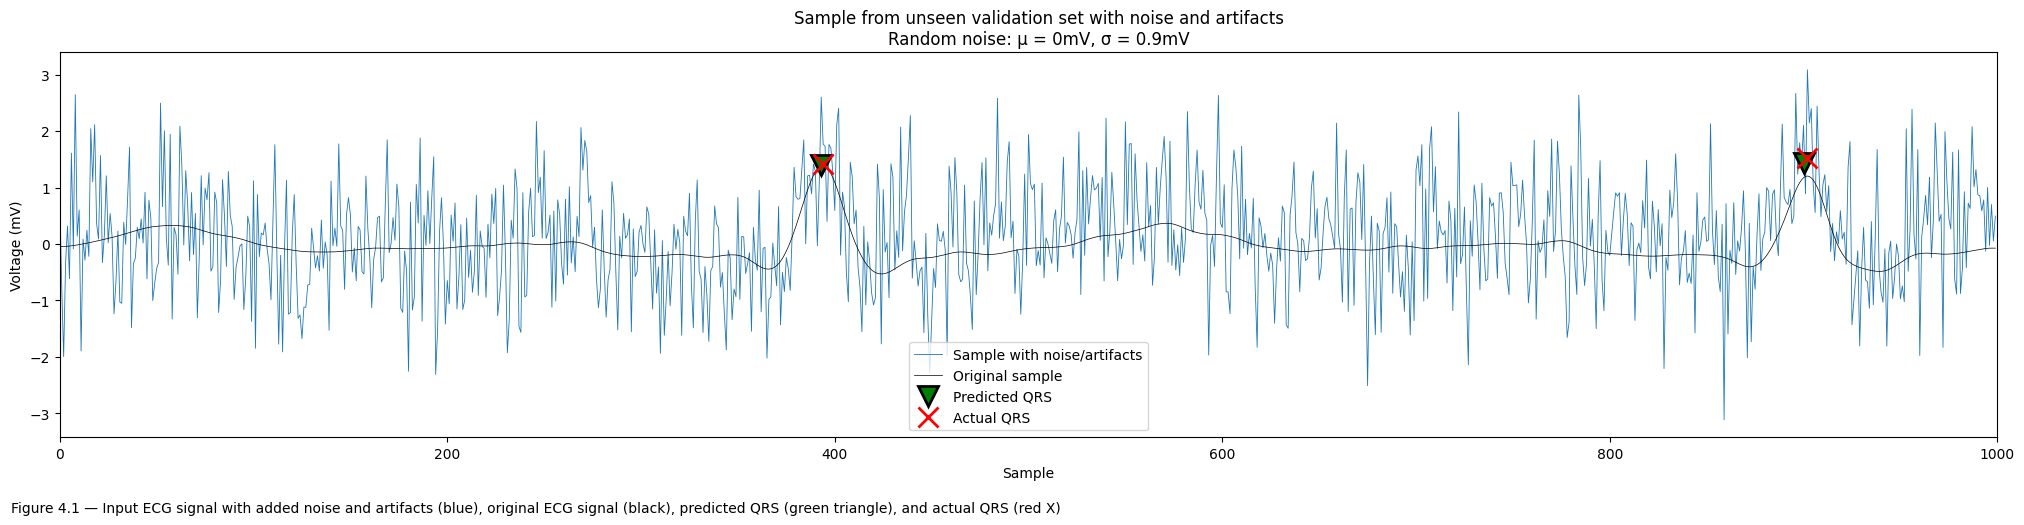

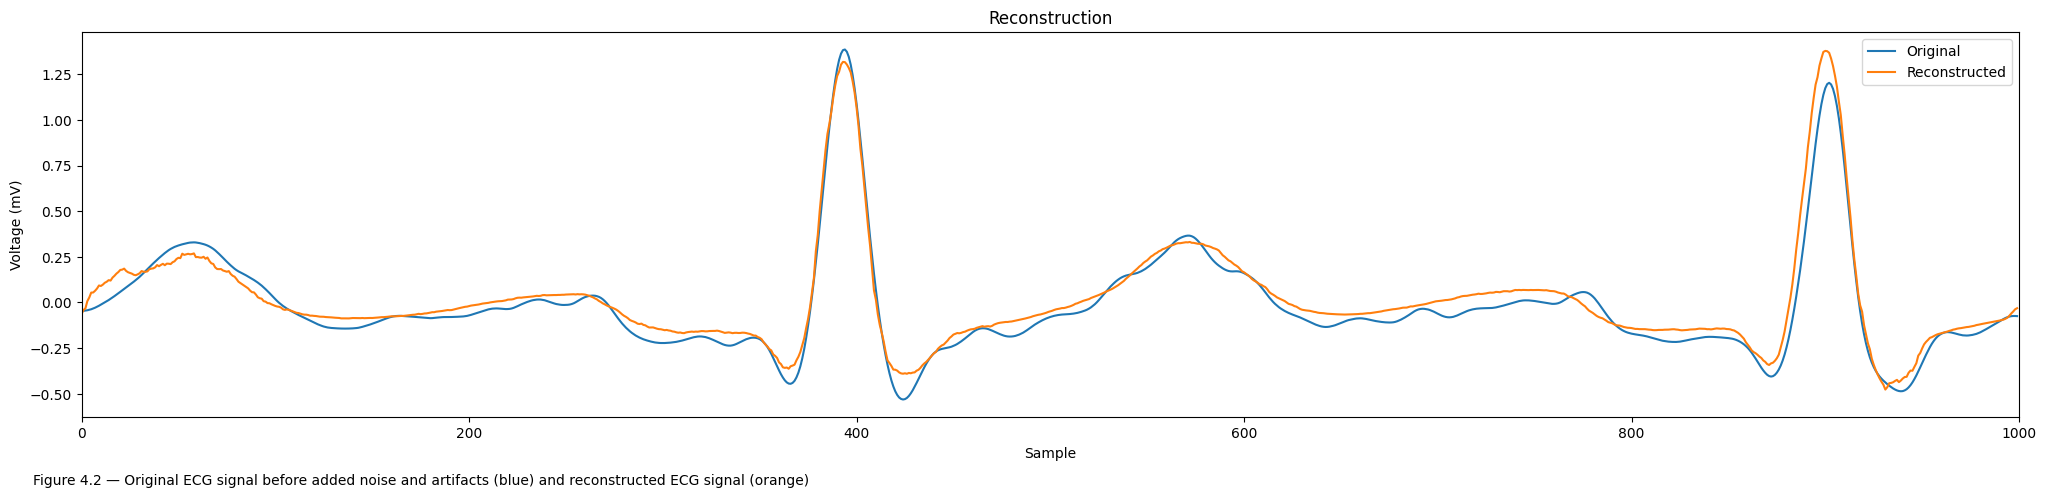

In [87]:
validation_sample_original = X_valid[np.random.randint(0, X_valid.shape[0])]

# signal drift
drift_factor = 5e-10 * np.random.normal()
drift_array = np.arange(1,sample_length+1)**3
offset = np.array([[drift_factor * drift_array]]).T

# bump artifact
bump = np.zeros(shape=sample_length)
bump[2_000:] = (1/(sample_length - 2_000))*np.arange(2_000, sample_length) + 1.75
bump = np.expand_dims(bump, axis=(1,2))

# instrumentation noise
mu, sigma = 0, 0.9
lead_noise = np.array([generate_lead_noise_2D(sample_length).T]).T
random_noise = np.random.normal(mu, sigma, (X_valid.shape[1],1,1))

# power line interferance
pli = 0.25*np.sin(2*np.pi*np.linspace(0,1,sample_length)*60_000)
pli = np.expand_dims(pli, axis=(1,2))


validation_sample_noisy = (
    validation_sample_original
    + random_noise
    + offset
    + lead_noise
    + bump
    + pli
)

validation_sample_noisy = np.expand_dims(validation_sample_noisy, axis=0)
full_model_validation = ecg_filter(validation_sample_noisy)[0,:,0,:]
###########################################################################################

plt.figure(figsize=(25,5))
plt.plot(
    validation_sample_noisy[0,:,0,0],
    linewidth=0.6
)
plt.plot(
    validation_sample_original[:,0,0],
    color='black',
    linewidth=0.5
)
predicted_qrs, _ = sp.signal.find_peaks(full_model_validation[:,0], height=0.6, prominence=0.6, width=10)
plt.plot(
    predicted_qrs,
    validation_sample_original[predicted_qrs,0] + offset[predicted_qrs,0] + lead_noise[predicted_qrs,0] + bump[predicted_qrs,0],
    "v",
    markeredgecolor='black',
    markerfacecolor='green',
    markersize=15,
    markeredgewidth=2,
)


actual_qrs, _ = sp.signal.find_peaks(validation_sample_original[:,0,0], distance=300, width=10, prominence=0.75)

plt.plot(
    actual_qrs,
    validation_sample_original[actual_qrs,0,0] + offset[actual_qrs,0,0] + lead_noise[actual_qrs,0,0] + bump[actual_qrs,0,0],
    "x",
    markeredgecolor='red',
    markersize=15,
    markeredgewidth=2,
)
plt.xlim([0,sample_length])
plt.title(f"""\
    Sample from unseen validation set with noise and artifacts
    Random noise: μ = {mu}mV, σ = {sigma}mV""")
plt.xlabel("Sample")
plt.ylabel("Voltage (mV)")
plt.legend(['Sample with noise/artifacts','Original sample','Predicted QRS','Actual QRS'])
plt.text(
    x=-25,
    y=-4.75,
    s="Figure 4.1 — Input ECG signal with added noise and artifacts (blue), original ECG signal (black), predicted QRS (green triangle), and actual QRS (red X)"
)
plt.show()

plt.figure(figsize=(25,5))
plt.plot(validation_sample_original[:,0,0])
plt.plot(full_model_validation)
plt.title("Reconstruction")
plt.xlabel("Sample")
plt.ylabel("Voltage (mV)")
plt.xlim([0,sample_length])
plt.legend(["Original", "Reconstructed"])
plt.text(
    x=-25,
    y=-1,
    s="Figure 4.2 — Original ECG signal before added noise and artifacts (blue) and reconstructed ECG signal (orange)"
)
plt.show()
